# Convert earthquake data downloaded from the USGS ANSS ComCat

This notebook reads in data downloaded from the USGS ANSS ComCat. It filters the earthquakes to those with magnitudes calculated by moment magnitude (MW) and local magnitude (ML).
It then uses scaling relationships to convert ML to MW. Based on empirical scaling relationships for Californian earthquakes (Bakun, 1984; Thatcher and Hanks, 1973), we can relate ML to seismic moment (Mo) using the relationship.

log(Mo) = 1.5 ML + 16.0

We can relate seismic moment to moment magnitude (Hanks and Kanamori, 1945):

Mw = 2/3(log(Mo) - 9.05)

In [2]:
# import modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd

## Read in the earthquake data

Firstly read in the CSV file downloaded from ComCat. This particular file has all historical earthquakes within 25 km of the San Andreas fault of M > 3

In [3]:
DataDirectory = '/home/bjdd72/san_andreas/Earthquakes/'
df = pd.read_csv(DataDirectory+'SAF_earthquakes_25km_dist.csv')

/home/bjdd72/miniconda3/envs/fault-swath/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print(df.columns)

Index(['id', 'time', 'latitude', 'longitude', 'depth', 'magnitude', 'location',
       'magtype', 'url', 'eventtype',
       ...
       'us_Mwb_mrp', 'us_Mwb_mtp', 'us_Mwb_np1_strike', 'us_Mwb_np1_dip',
       'us_Mwb_np1_rake', 'us_Mwb_np2_strike', 'us_Mwb_np2_dip',
       'us_Mwb_np2_rake', 'fault_dist', 'direction'],
      dtype='object', length=170)


In [5]:
df = df[df['magtype'].isin(['mw','ml'])]
print(df)

              id        time   latitude   longitude   depth  magnitude  \
4      ci3358532  1932/02/05  36.000000 -120.500000   6.000       3.60   
6      ci3358630  1932/03/07  36.267333 -120.697333   6.000       3.12   
7      ci3358794  1932/04/21  35.954333 -120.713500   6.000       3.21   
8      ci3358966  1932/05/06  33.966500 -116.252667   6.000       3.25   
9      ci3358977  1932/05/10  33.992833 -116.301500   6.000       3.25   
...          ...         ...        ...         ...     ...        ...   
6118  nc71627835  2011/08/27  36.584333 -121.180833   7.500       4.64   
6119  nc71863625  2012/10/21  36.309667 -120.856000   8.619       5.29   
6120  ci15520985  2014/07/05  34.282333 -117.026667   7.250       4.58   
6121  nc72923380  2017/11/13  36.630500 -121.244333   6.310       4.58   
6122  nc73292360  2019/10/15  36.645500 -121.274000  10.100       4.71   

                             location magtype  \
4           13km NNW of Parkfield, CA      ml   
6            

In [6]:
print(df.magtype.unique())

['ml' 'mw']


## Plot the earthquakes as a time series

Firstly, let's plot the magnitude of the earthquakes through time. The earthquake magnitudes are calculated using a number of different methods: we want to visualise how this compares with time, so we'll colour each earthquake by the method used to calculate the magnitude. 

In [7]:
# Convert the dataframe index to a pandas datetime
df.index = pd.to_datetime(df['time'])

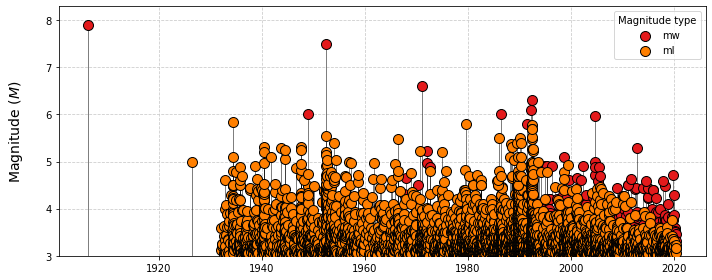

In [8]:
# set up a figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.grid(color='0.8', linestyle='--', which='both')
# make a stem plot
markerline, stemlines, baseline = ax.stem(df.index, df.magnitude, linefmt='k', use_line_collection=True)
# adjust the markers and lines
markerline.set_markeredgecolor('k')
stemlines.set_linewidth(0.5)
baseline.set_color('white')

# add a scatter plot to set the colour of the markers to reflect the magnitude type
# Get unique names of magnitude types
uniq = list(set(df['magtype']))

# Set the color map to match the number of types
z = range(1,len(uniq))
# Define the color map and normalize to total number of types
hot = plt.get_cmap('Set1')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=hot)
print(scalarMap)
# Plot each magnitude type separately
for i in range(len(uniq)):
    this_df = df[df['magtype'] == uniq[i]]
    plt.scatter(this_df.index, this_df.magnitude, s=100, color=scalarMap.to_rgba(i), edgecolor='k', label=uniq[i], zorder=100)

# configure plot options
plt.ylabel('Magnitude ($M$)', fontsize=14, labelpad=20)
plt.xlabel('', fontsize=14)
plt.ylim(3,)
plt.legend(title = 'Magnitude type')
plt.tight_layout()

In [9]:
# Now save the figure
fig.savefig(DataDirectory+'SAF_earthquakes_25km_timeseries.png', dpi=300)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Remove earthquakes from before 1940

In this step we'll filter the dataframe to remove any earthquakes from before 1940. This is because the Richter scale was only developed in ~1935, and any estimates before this are not reliable.

In [10]:
start_date = '1940-01-01'
mask = df.index > start_date
df = df.loc[mask]

In [14]:
df.index.min()

Timestamp('1940-01-07 00:00:00')

## Convert all magnitudes to moment magnitude

Use the scaling relationships to convert ML to seismic moment, and then to MW

In [17]:
def convert_to_mw(x):
    """
    Convert ML to Mw
    """
    mo = 1.5*x + 16.0
    mw = (2/3)*mo - 10.7
    return mw
   
# make a Mw column by converting all values to Mw
df['Mw'] = df['magnitude'].map(convert_to_mw)
# make a mask for values which already had magnitude calculated by 'mw' and copy these over
mask = (df['magtype'] == 'mw')
df['Mw'][mask] = df['magnitude']

<ipython-input-17-b862877b99b6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mw'][mask] = df['magnitude']


Convert the final Mw values to seismic moment - this can be used to sum the energy released at various 

In [22]:
def convert_to_mo(x):
    """
    Convert Mw to Mo 
    """
    mo = 10**(1.5*(x+10.7))
    print(mo)
    # convert to Nm (divide by 10^7)
    return mo/1e7

df['Mo'] = df['Mw'].map(convert_to_mo)

9.225714271547628e+20
9.225714271547628e+20
5.888436553555884e+20
4.78630092322638e+20
2.113489039836626e+21
3.8459178204535435e+22
3.3884415613920346e+20
1.6032453906900352e+21
7.498942093324558e+20
5.4954087385762706e+20
3.758374042884405e+20
2.7227013080779265e+22
4.3151907682776325e+20
2.8840315031266116e+21
1.7988709151287837e+22
3.0199517204020193e+22
1.1481536214968887e+22
2.264644307593062e+21
9.332543007969886e+21
2.371373705661655e+22
8.317637711026743e+20
7.762471166286927e+20
3.311311214825908e+21
7.58577575029182e+21
7.762471166286927e+20
6.095368972401643e+20
9.660508789898121e+21
9.549925860214369e+20
5.888436553555884e+20
3.5075187395256936e+20
3.4673685045253096e+22
1.7782794100389228e+21
8.912509381337367e+20
6.53130552647469e+20
4.027170343254595e+20
1.927524913190921e+22
3.0199517204020193e+22
8.317637711026743e+20
3.630780547701032e+20
2.691534803926914e+21
1.6032453906900352e+21
7.328245331389075e+21
4.78630092322638e+20
3.3496543915782655e+22
6.760829753919791e+2

In [23]:
df['Mo']

time
1940-01-07    9.225714e+13
1940-01-16    9.225714e+13
1940-01-19    5.888437e+13
1940-02-08    4.786301e+13
1940-02-09    2.113489e+14
                  ...     
2011-08-27    1.023293e+16
2012-10-21    9.660509e+16
2014-07-05    8.317638e+15
2017-11-13    8.317638e+15
2019-10-15    1.303167e+16
Name: Mo, Length: 4064, dtype: float64

In [24]:
# save the new dataframe
df.to_csv(DataDirectory+'SAF_earthquakes_25km_dist_Mw.csv', index=False)

## Make a magnitude-frequency plot

One of the most common plots of earthquake records we can make is a plot of magnitude and frequency. This is often used for seismic hazard assessment.

In [19]:
# Firstly, let's group the dataframe by the magnitude
gr = df.groupby(['Mw'])['time'].agg(['count']).reset_index()

Text(0, 0.5, 'log(Frequency)')

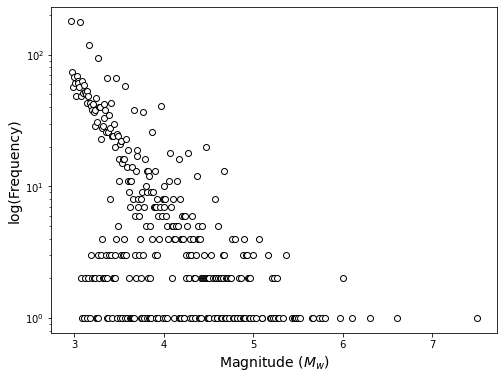

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plt.scatter(gr['Mw'], gr['count'], edgecolor='k', facecolor='white')
plt.yscale('log')
plt.xlabel('Magnitude ($M_w$)', fontsize=14)
plt.ylabel('log(Frequency)', fontsize=14)